In [11]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os

In [7]:
X_train = pd.read_csv("data/X_train.csv", index_col=0).astype(float)
y_train = pd.read_csv("data/y_train.csv", index_col=0).astype(int)
y_train = pd.Series(y_train.values.ravel())
y_train.index = X_train.index

y_train_binary = pd.read_csv("data/y_train_binary.csv", index_col=0).astype(int)
y_train_binary = pd.Series(y_train_binary.values.ravel())
y_train_binary.index = X_train.index

X_test = pd.read_csv("data/X_test.csv", index_col=0).astype(float)
y_test = pd.read_csv("data/y_test.csv", index_col=0).astype(int)
y_test = pd.Series(y_test.values.ravel())
y_test.index = X_test.index

y_test_binary = pd.read_csv("data/y_test_binary.csv", index_col=0).astype(int)
y_test_binary = pd.Series(y_test_binary.values.ravel())
y_test_binary.index = X_test.index

In [8]:
# Stage 1: Train kNN for binary classification (0 vs 1+2)
knn_stage1 = KNeighborsClassifier(n_neighbors=5)
knn_stage1.fit(X_train, y_train_binary)
y_pred_binary = knn_stage1.predict(X_test)
y_proba_stage1 = knn_stage1.predict_proba(X_test)

print("\nStage 1 Classification Report (0 vs 1+2):")
print(classification_report(y_test_binary, y_pred_binary))

# Stage 2: Train kNN for classifying 1 vs 2
# Filter training data for stage 2
X_train_diabetes = X_train[y_train_binary == 1]
y_train_diabetes = y_train[y_train_binary == 1]

# Filter test data for samples predicted as diabetic
pred_diabetes_indices = np.where(y_pred_binary == 1)[0]
X_test_diabetes = X_test.iloc[pred_diabetes_indices]
y_test_full = y_test.loc[y_test_binary.index]
y_test_diabetes = y_test_full.iloc[pred_diabetes_indices]

# Keep only class 1 and 2
valid_mask = (y_test_diabetes == 1) | (y_test_diabetes == 2)
X_test_diabetes = X_test_diabetes[valid_mask]
y_test_diabetes = y_test_diabetes[valid_mask]

# Fit and predict stage 2
knn_stage2 = KNeighborsClassifier(n_neighbors=5)
knn_stage2.fit(X_train_diabetes, y_train_diabetes)
y_pred_stage2 = knn_stage2.predict(X_test_diabetes)
y_proba_stage2 = knn_stage2.predict_proba(X_test_diabetes)

print("\nStage 2 Classification Report (1 vs 2):")
print(classification_report(y_test_diabetes, y_pred_stage2))

# Reconstruct final predictions
y_pred_final = y_pred_binary.copy()

# Replace predictions of class 1 with either 1 or 2 from stage 2
valid_indices = pred_diabetes_indices[valid_mask.values]
for i, idx in enumerate(valid_indices):
    y_pred_final[idx] = y_pred_stage2[i]

print("\nFinal Classification Report for 2-Stage kNN with Undersamplin:")
print(classification_report(y_test_full, y_pred_final))


Stage 1 Classification Report (0 vs 1+2):
              precision    recall  f1-score   support

           0       0.93      0.52      0.67     38012
           1       0.26      0.81      0.40      7945

    accuracy                           0.57     45957
   macro avg       0.60      0.67      0.53     45957
weighted avg       0.81      0.57      0.62     45957


Stage 2 Classification Report (1 vs 2):
              precision    recall  f1-score   support

           1       0.11      0.73      0.19       673
           2       0.91      0.32      0.48      5744

    accuracy                           0.37      6417
   macro avg       0.51      0.52      0.34      6417
weighted avg       0.83      0.37      0.45      6417


Final Classification Report for 2-Stage kNN with Undersamplin:
              precision    recall  f1-score   support

           0       0.93      0.52      0.67     38012
           1       0.02      0.53      0.04       926
           2       0.91      0.26  

In [12]:
os.makedirs("results", exist_ok=True)

# Save final kNN predictions for ensemble voting
np.save("results/y_pred_knn.npy", y_pred_final)

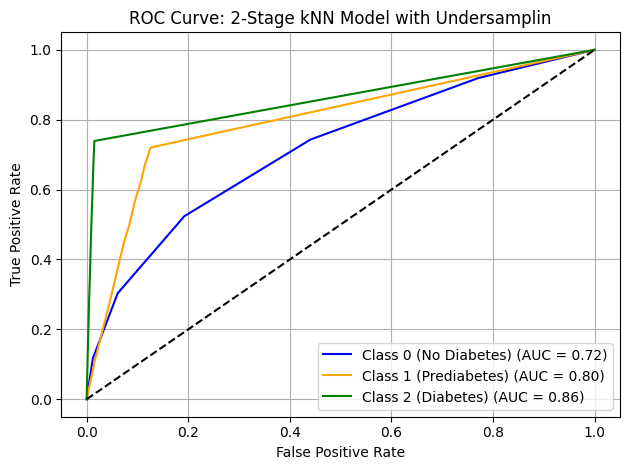

In [9]:
y_score = np.zeros((len(X_test), 3))
y_score[:, 0] = y_proba_stage1[:, 0]  # P(class 0)

# Get stage 2 probs into y_score
for i, idx in enumerate(X_test_diabetes.index):
    global_idx = X_test.index.get_loc(idx)
    diabetes_prob = y_proba_stage1[global_idx, 1]  # P(class 1+2)
    y_score[global_idx, 1] = diabetes_prob * y_proba_stage2[i, 0]
    y_score[global_idx, 2] = diabetes_prob * y_proba_stage2[i, 1]

# Binarize true labels
y_test_bin = label_binarize(y_test_full, classes=[0, 1, 2])

# Compute ROC and AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure()
colors = ['blue', 'orange', 'green']
labels = ['Class 0 (No Diabetes)', 'Class 1 (Prediabetes)', 'Class 2 (Diabetes)']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: 2-Stage kNN Model with Undersamplin")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

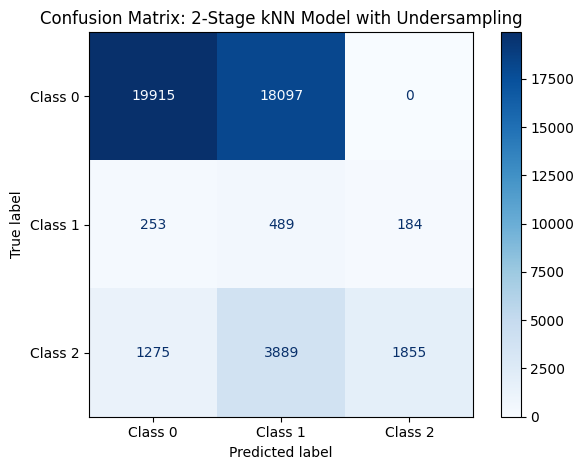

In [10]:
cm = confusion_matrix(y_test_full, y_pred_final, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: 2-Stage kNN Model with Undersampling")
plt.grid(False)
plt.tight_layout()
plt.show()